# Imports

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import copy

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Data loading and preprocessing
Remember to change the path if needed be

### Hyperparameters of preprocessing

In [2]:
m = 2000; M = 20000; 
bin_size = 50;

# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = "C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/"

# # Take the data from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Kaggle_data/"
# path_results = "/content/drive/My Drive/Colab Notebooks/Kaggle/Kaggle_results/"

In [3]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [4]:
def spectrum_in_bins(df,m,M,bin_size):
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_label = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_label.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum
                idx_data_in_bins[0,i] = 0   

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_label, index = df.index)
    return new_df

In [39]:
# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=25) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins(data_test_train,m,M,bin_size)
print('Spectrum regularized!')
# these spectrum_... are our X for training

Training samples: 361 and test_train samples: 155
Spectrum regularized!


In [6]:
def clean_nan_samples(spectrum,targets, c, cat):
# if there are any NaN values, we should remove those samples
    if (targets[cat].isnull().sum() > 0).all(): 
        merged = pd.concat([spectrum , targets],axis=1,copy=True)
        clean = merged.dropna(subset=[cat])
        print('Dropped ',len(merged)-len(clean))
        Y = clean.iloc[:,-9+c].to_numpy().reshape(-1,)
        X = clean.iloc[:,:-9]

    else:
        Y = targets.iloc[:,c].to_numpy().reshape(-1,)
        X = spectrum.copy(deep=True)
    return X , Y

# Try different classifiers
The try_clf function has been built for, given a classifier and a parameter dictionary (for hyperparameter cross-validation), create a classifier for each antibiotic, and return the results. This enables for fast testing of different classifiers. Moreover, the function also takes charge of suppressing NaN values in the targets ocurring for amikacina, levofloxacino and tobramicina.

In [7]:
def try_clf(clf,params,n_cv=10):
    t1 = time.time()
    
    best_classifiers = [];
    accuracies_train = []; accuracies_test_train = [];
    AUC_train = []; AUC_test_train = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params, cv=n_cv, iid=False)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        
        # compute the accuracy of the classifier
        acc_train = best_clf.score(X_train, Y_train)
        acc_test = best_clf.score(X_test_train, Y_test_train)
        print('Train accuracy: ',np.round(acc_train,4),' and test_train accuracy: ',np.round(acc_test,4))
        accuracies_train.append(acc_train)
        accuracies_test_train.append(acc_test)
        
        # compute the AUC of the classifier
        if callable(getattr(best_clf,"predict_proba",None)):
            pred_train = best_clf.predict_proba(X_train)[:,-1] # only take last column, the prob of Y = +1
            pred_test = best_clf.predict_proba(X_test_train)[:,-1]
        else:
            print('Using decision_function instead of predict_proba')
            pred_train = best_clf.decision_function(X_train)
            pred_test = best_clf.decision_function(X_test_train)            
        auc_score_train = roc_auc_score(Y_train, pred_train)
        auc_score_test = roc_auc_score(Y_test_train, pred_test)
        print('Train AUC: ',np.round(auc_score_train,4),' and test_train AUC: ',np.round(auc_score_test,4))
        AUC_train.append(auc_score_train)
        AUC_test_train.append(auc_score_test)
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_test_train = np.mean(AUC_test_train)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg test_train AUC is',np.round(avg_AUC_test_train,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, accuracies_train, accuracies_test_train, AUC_train, AUC_test_train

## Also enable L1 feature selection

In [8]:
def get_l1_clfs():
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(penalty='l1',solver='liblinear',max_iter=1e6, class_weight='balanced')
    params = {'C':10.**np.arange(-2,5)}
    l1_best_clfs,_,_,_,_ = try_clf(clf,params)
    return l1_best_clfs

def obtain_l1_vects(l1_best_clfs,spectrum_train,targets_train):
    l1_feat_list = []    
    categories = targets_train.columns[:]
    
    for c, cat in enumerate(categories):
        n = np.sum(np.abs(l1_best_clfs[c].coef_) > 0)
        print('Number of features:',n)
        while n == 0:
            clf = l1_best_clfs[c]
            c_value = clf.get_params()['C']
            new_c = c_value * 10
            clf.set_params(C=new_c)
            X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)            
            clf.fit(X_train, Y_train) # refit with higher C
            l1_best_clfs[c] = clf
            n = np.sum(np.abs(clf.coef_) > 0)
            print(n)
    
        # once we know we have at least one non-zero feature
        vect = (np.abs(l1_best_clfs[c].coef_)>0).reshape(-1,)
        l1_feat_list.append(vect)
    return l1_feat_list

# to be applyied to each category
def apply_l1_feature_selection(spectrum_train,vect): # vect is l1_feat_list[c]
    new_spectrum = spectrum_train.copy(deep=True).iloc[:,vect]   
    return new_spectrum

In [9]:
def try_clf_feat_selection(clf, params, feature_vector_list, n_cv=10):
    t1 = time.time()
    
    best_classifiers = [];
    accuracies_train = []; accuracies_test_train = [];
    AUC_train = []; AUC_test_train = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
        
        X_train = apply_l1_feature_selection(X_train,feature_vector_list[c])
        X_test_train = apply_l1_feature_selection(X_test_train,feature_vector_list[c])
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params, cv=n_cv, iid=False)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        
        # compute the accuracy of the classifier
        acc_train = best_clf.score(X_train, Y_train)
        acc_test = best_clf.score(X_test_train, Y_test_train)
        print('Train accuracy: ',np.round(acc_train,4),' and test_train accuracy: ',np.round(acc_test,4))
        accuracies_train.append(acc_train)
        accuracies_test_train.append(acc_test)
        
        # compute the AUC of the classifier
        if callable(getattr(best_clf,"predict_proba",None)):
            pred_train = best_clf.predict_proba(X_train)[:,-1] # only take last column, the prob of Y = +1
            pred_test = best_clf.predict_proba(X_test_train)[:,-1]
        else:
            print('Using decision_function instead of predict_proba')
            pred_train = best_clf.decision_function(X_train)
            pred_test = best_clf.decision_function(X_test_train)            
        auc_score_train = roc_auc_score(Y_train, pred_train)
        auc_score_test = roc_auc_score(Y_test_train, pred_test)
        print('Train AUC: ',np.round(auc_score_train,4),' and test_train AUC: ',np.round(auc_score_test,4))
        AUC_train.append(auc_score_train)
        AUC_test_train.append(auc_score_test)
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_test_train = np.mean(AUC_test_train)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg test_train AUC is',np.round(avg_AUC_test_train,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, accuracies_train, accuracies_test_train, AUC_train, AUC_test_train

In [10]:
with open(path+'l1_best_clfs.data', 'rb') as filehandle:
    # read the data as binary data stream
    l1_best_clfs = pickle.load(filehandle)
with open(path+'l1_feat_list.data', 'rb') as filehandle:
    # store the data as binary data stream
    l1_feat_list = pickle.load(filehandle)

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Real AdaBoost with HW2 method

In [40]:
from sklearn.metrics import accuracy_score as acc

def RAEnsemble(X_train, Y_train, X_test, Y_test, T):
  '''
  Train and evaluate a bagged ensemble of decission trees

    Args:
        X_train(numpy dnarray): training (number training data x number dimensions). 
        Y_train (numpy dnarray): labels of the training data (number training data x 1).
        X_test(numpy dnarray): test data to evaluate the ensemble performance (number test data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number test data x 1).
        T: number of learners in the ensemble                                        
   Returns:
        acc_tree_train (numpy dnarray): accuracy over the training data for different number of learners. 
                It's a vector length T, where the t-th element is the ensemble accuracy when only t trees are used.
        acc_tree_test (numpy dnarray): accuracy over the test data for different number of learners. 
                It's a vector length T, where the t-th element is the ensemble accuracy when only t trees are used.
        Y_pred_train (numpy dnarray): predicted outputs over the training data. It's a matrix of dimensions T x number of training samples, 
          where the t-th row has the predicted outputs when t trees are used.
        Y_pred_test (numpy dnarray): predicted outputs over the test data. It's a matrix of dimensions T x number of test samples, 
          where the t-th row has the predicted outputs when t trees are used.
        alpha (numpy dnarray): weight vector of length T with the ouput weights assigned to combine the learner's outputs.
        Dt_all (numpy dnarray): emphasis function used to train each learner. It's a matrix of dimensions T x number of training samples, 
          where the t-th row has the emphasis function used by the t-th learner.

  '''  
  # <SOL>
  acc_tree_train = np.zeros((T,))
  acc_tree_test = np.zeros((T,))    

  auc_tree_train = np.zeros((T,))
  auc_tree_test = np.zeros((T,))
    
  auc_ensemble_train = np.zeros((T,))
  auc_ensemble_test = np.zeros((T,))

  Y_pred_train = np.zeros((T,Y_train.shape[0]))
  Y_pred_test  = np.zeros((T,Y_test.shape[0]))

  alpha = np.zeros((T,1))
  Dt_all = np.zeros((T,X_train.shape[0]))

  outputs_train = np.zeros((T,Y_train.shape[0]))
  outputs_test  = np.zeros((T,Y_test.shape[0]))

  f_train = np.zeros((T,Y_train.shape[0]))
  f_test  = np.zeros((T,Y_test.shape[0]))

  Dt_all[0,:] = np.ones((1,X_train.shape[0])) / X_train.shape[0]  # Initialize all weights as 1 / n_samples
  for i in range(T):
    mytree = DecisionTreeClassifier(max_depth=2)
    mytree.fit(X_train,Y_train,sample_weight=Dt_all[i,:])

    # For real-valued predictions:
    outputs_train[i,:] = np.dot(mytree.predict_proba(X_train),mytree.classes_)
    outputs_test[i,:]  = np.dot(mytree.predict_proba(X_test) ,mytree.classes_)
#     print(mytree.classes_)
    # Get individual tree AUC
    auc_tree_train[i] = roc_auc_score(Y_train, outputs_train[i,:])
    auc_tree_test[i] = roc_auc_score(Y_test, outputs_test[i,:])

    # Get gamma and alpha_i values
    gamma = np.dot(Dt_all[i,:],np.multiply(outputs_train[i,:],Y_train))
    alpha[i] = 0.5 * np.log((1+gamma)/(1-gamma))

    # Update emphasis function (except if in the last iteration)
    if (i < T-1):
      emphasis = np.multiply(Dt_all[i,:],np.exp(-1*alpha[i]*np.multiply(outputs_train[i,:],Y_train)))
      Dt_all[i+1,:] = emphasis / np.sum(emphasis) # normalize

    # Now let's obtain the f values (outputs of each tree * alphas)
    f_train[i,:] = np.sum(np.multiply(outputs_train[0:i+1,:],alpha[0:i+1]) , axis=0) #/ np.sum(alpha[0:i+1])
    f_test[i,:]  = np.sum(np.multiply(outputs_test[0:i+1,:],alpha[0:i+1])  , axis=0) #/ np.sum(alpha[0:i+1])

    # Depending on whether f_i is greater or smaller than 0, set the label to +1 or -1
    predicted_labels_train = copy.deepcopy(f_train[i,:])
    predicted_labels_train[predicted_labels_train >=0] = 1
    predicted_labels_train[predicted_labels_train < 0] = -1
    Y_pred_train[i,:] = predicted_labels_train
    acc_tree_train[i] = acc(Y_train,Y_pred_train[i,:])

    predicted_labels_test = copy.deepcopy(f_test[i,:])
    predicted_labels_test[predicted_labels_test >=0] = 1
    predicted_labels_test[predicted_labels_test < 0] = -1
    Y_pred_test[i,:] = predicted_labels_test
    acc_tree_test[i] = acc(Y_test,Y_pred_test[i,:])
    
    auc_ensemble_train[i] = roc_auc_score(Y_train,f_train[i,:])
    auc_ensemble_test[i] = roc_auc_score(Y_test,f_test[i,:])


  # </SOL>
  return Y_pred_train, Y_pred_test, acc_tree_train, acc_tree_test,  alpha, Dt_all, f_train, f_test, auc_tree_train, auc_tree_test, auc_ensemble_train, auc_ensemble_test

In [53]:
categories = targets_train.columns[:]
c = 0; cat = categories[c];

X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
Y_train[Y_train==0] = -1
Y_test_train[Y_test_train==0] = -1

In [59]:
T = 2000
Y_pred_train, Y_pred_test, acc_tree_train, acc_tree_test,  alpha, Dt_all, f_train, f_test, auc_tree_train, auc_tree_test, auc_ensemble_train, auc_ensemble_test = RAEnsemble(X_train, Y_train, X_test_train, Y_test_train, T);

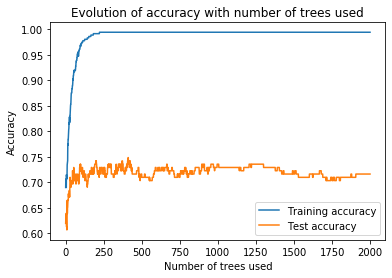

In [60]:
 # Evolution of accuracy with the number of trees used
 plt.figure()
 plt.plot(acc_tree_train,label='Training accuracy')
 plt.plot(acc_tree_test,label='Test accuracy')
 plt.title('Evolution of accuracy with number of trees used')
 plt.xlabel('Number of trees used')
 plt.ylabel('Accuracy')
 plt.legend()
 plt.show()

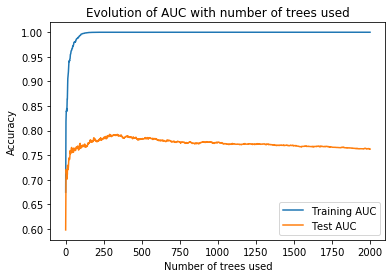

In [62]:
 plt.figure()
 plt.plot(auc_ensemble_train,label='Training AUC')
 plt.plot(auc_ensemble_test,label='Test AUC')
 plt.title('Evolution of AUC with number of trees used')
 plt.xlabel('Number of trees used')
 plt.ylabel('Accuracy')
 plt.legend()
 plt.show()

ROC_curve + ROC_AUC method: 	 0.7625948930296756


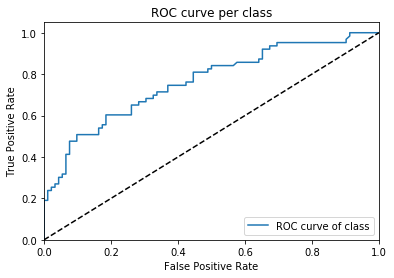

In [63]:
# roc_curve + auc methods (same, but also enables plotting)
fpr, tpr, _ = roc_curve(Y_test_train,f_test[-1,:])
roc_auc = auc(fpr, tpr)
print ('ROC_curve + ROC_AUC method: \t',roc_auc )

plt.plot(fpr, tpr, label='ROC curve of class')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per class')
plt.legend(loc="lower right")
plt.show()

#### CLINDAMICINA
The 4th antibiotic, clindamicina, is one of the hardest to classify (most methods yield AUC = 0.6 or below). Let's try.

In [64]:
categories = targets_train.columns[:]
c = 4; cat = categories[c];
# this antibiotic is one of the hardest to classify

X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
Y_train[Y_train==0] = -1
Y_test_train[Y_test_train==0] = -1

In [65]:
T = 2000
Y_pred_train, Y_pred_test, acc_tree_train, acc_tree_test,  alpha, Dt_all, f_train, f_test, auc_tree_train, auc_tree_test, auc_ensemble_train, auc_ensemble_test = RAEnsemble(X_train, Y_train, X_test_train, Y_test_train, T);

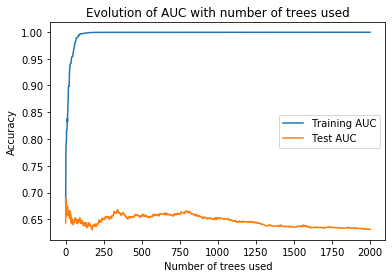

In [66]:
 plt.figure()
 plt.plot(auc_ensemble_train,label='Training AUC')
 plt.plot(auc_ensemble_test,label='Test AUC')
 plt.title('Evolution of AUC with number of trees used')
 plt.xlabel('Number of trees used')
 plt.ylabel('Accuracy')
 plt.legend()
 plt.show()

Results are not very good, but actually somehow better than those of other methods (LogReg, RF...). Remarkably, they are substantially better than those of AdaBoostClassifier of sklearn (with 200 estimators, also depth 2, it yields 0.5644).

# Sklearn AdaBoost
Let's now try the sklearn method, but without CV. Lets use T = 500.

In [68]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=500)
classifier.fit(X_train,Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [73]:
pred = classifier.predict_proba(X_test_train)[:,1]
auc_test = roc_auc_score(Y_test_train,pred)
print('AUC for test_train set with sklearn AdaBoost: ',auc_test)

pred = classifier.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(Y_train,pred)
print('AUC for train set with sklearn AdaBoost: ',auc_train)

AUC for test_train set with sklearn AdaBoost:  0.6013719512195123
AUC for train set with sklearn AdaBoost:  0.9994172494172494


I don't know why, this method performs worse.

## Implementing AdaBoost for all categories, and getting Y_test predictions

In [ ]:
# TODO

# Generate final results in CSV format
From "Jagger_4_GenerateCSV_v2"

In [ ]:
def get_unique_spectre(spectre, df):
  # Include the ID_sample column for the group_by
  spectre['ID_sample'] = df.ID_sample
  # MEAN OF THE SPECTRE
  spectre = spectre.groupby('ID_sample').mean().reset_index()
  return spectre

def generate_csv_from_clf(clf_list, path, path_results, file_name):
  # classifiers must be provided with parameters, and in a list [clf_antibiotic0, clf_antibiotic1, ...]
  # spectrum and targets full train (containing all training points) will be used for training the clfs in clf list
  # df_test must be provided as loaded from the file

  # read all data from files
  zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
  df_full_train = _pickle.loads(zf.open('TrainData.pkl').read());   zf.close()

  zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
  df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read());   zf.close()

  # Process test df to get UNIQUE samples and convert to spectrum

  # df_unique_test = df_test.drop_duplicates(subset='ID_sample')

  spectrum_test_forcsv = spectrum_in_bins(df_test,m,M,bin_size)
  spectrum_test_forcsv = get_unique_spectre(spectrum_test_forcsv, df_test)

  # Process train set to later train the clfs
  spectrum_full_train = spectrum_in_bins(df_full_train.iloc[:,-2:],m,M,bin_size)
  targets_full_train  = df_full_train.iloc[:,1:-2]  

  # read the submission example file
  df_submission = pd.read_csv(path+'SubmissionSample.csv') 
  categories = df_submission.columns[1:]
  df_submission['ID']= spectrum_test_forcsv['ID_sample'].values
  # To eliminate the ID_sample from the spectrum
  spectrum_test_forcsv = spectrum_test_forcsv.drop(columns=['ID_sample'])
  for c, cat in enumerate(categories): 
      # clean NaN values
      X_train, Y_train = clean_nan_samples(spectrum_full_train,targets_full_train, c, cat)

      # fit the classifier
      clf_base = clf_list[c].fit(X_train,Y_train)
      # Compute its test prestiction and save this output
      o_test = clf_base.predict_proba(spectrum_test_forcsv)[:,1]
      df_submission[cat] = o_test

  # Save the dataframe with the predicted outputs
  df_submission = df_submission.set_index('ID')
  df_submission.to_csv(path_results + file_name + '.csv')
  print('DONE!')
  return df_submission

In [ ]:
# Let's create manually a list of good classifiers
clf_oxalacina       = #
clf_amikacina       = #
clf_amoxiclav       = #
clf_ciprofloxacino  = #
clf_clindamicina    = #
clf_eritromicina    = #
clf_levofloxacino   = #
clf_penicilina      = #
clf_tobramicina     = #

clf_list = [clf_oxalacina, clf_amikacina, clf_amoxiclav, clf_ciprofloxacino, clf_clindamicina,
            clf_eritromicina, clf_levofloxacino, clf_penicilina, clf_tobramicina]

In [ ]:
name = 'filename'
df_submission = generate_csv_from_clf(clf_list,path,path_results, name)
print('File: '+name+' has been successfully generated')